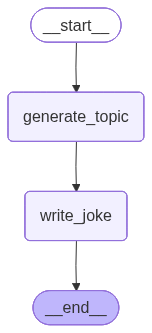

In [1]:
import uuid

from typing_extensions import TypedDict, NotRequired
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    topic: NotRequired[str]
    joke: NotRequired[str]

"""
model = init_chat_model(
    "claude-sonnet-4-5-20250929",
    temperature=0,
)
"""
from langchain_community.chat_models.tongyi import ChatTongyi
model = ChatTongyi( # type: ignore
    model="qwen3-max",
    model_kwargs={
        "temperature": 0.0,
        "enable_thinking": False,
    },
)


def generate_topic(state: State):
    """LLM call to generate a topic for the joke"""
    msg = model.invoke("Give me a funny topic for a joke")
    return {"topic": msg.content}


def write_joke(state: State):
    """LLM call to write a joke based on the topic"""
    msg = model.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_topic", generate_topic)
workflow.add_node("write_joke", write_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_topic")
workflow.add_edge("generate_topic", "write_joke")
workflow.add_edge("write_joke", END)

# Compile
checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
graph

In [2]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}
state = graph.invoke({}, config)

print(state["topic"])
print()
print(state["joke"])

How about this: **"Why don't skeletons ever start arguments?"**  

Because they don’t have the guts! 💀😄

Want another one?

Absolutely! Here's another one for you:

**"Why did the skeleton go to the party alone?"**  
Because he had no body to go with! 💀🎉

Want another? 😄


In [3]:
# The states are returned in reverse chronological order.
states = list(graph.get_state_history(config))

for state in states:
    print(state.next)
    print(state.config["configurable"]["checkpoint_id"])
    print()

()
1f0c7463-7eaa-6f65-8002-094de4bda26c

('write_joke',)
1f0c7463-71cf-67ff-8001-01b178186601

('generate_topic',)
1f0c7463-5bf9-6a3e-8000-3844adac58b9

('__start__',)
1f0c7463-5bf7-6679-bfff-7b6d375217bb



In [5]:
# This is the state before last (states are listed in chronological order)
selected_state = states[1]
print(selected_state.next)
print(selected_state.values)

('write_joke',)
{'topic': 'How about this: **"Why don\'t skeletons ever start arguments?"**  \n\nBecause they don’t have the guts! 💀😄\n\nWant another one?'}


In [6]:
new_config = graph.update_state(selected_state.config, values={"topic": "chickens"})
print(new_config)

{'configurable': {'thread_id': 'a32c27ae-dc35-4801-9889-dd1388abc6e1', 'checkpoint_ns': '', 'checkpoint_id': '1f0c7465-a684-69cb-8002-daf3242068e2'}}


In [8]:
graph.invoke(None, new_config)

{'topic': 'chickens',
 'joke': 'Why did the chicken join a band?  \nBecause it had the *drumsticks*! 🥁🐔'}